In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras import models, layers, regularizers, callbacks


In [20]:
# Load dataset
df = pd.read_csv("merged_weather_pm25.csv")
df = df.drop(columns=["name"])  # drop unhelpful cols
df.dropna(inplace=True)

# Sort by date to preserve temporal order
df['date'] = pd.to_datetime(df['date'])
df.sort_values('date', inplace=True)
df.drop(columns=['date'], inplace=True)

# Normalize
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# Separate features and target
target_index = df.columns.get_loc("pm25")

X_all = []
y_all = []
sequence_length = 7  # look back 7 days

for i in range(sequence_length, len(df)):
    X_all.append(scaled_data[i-sequence_length:i, :])
    y_all.append(scaled_data[i, target_index])  # predict pm25 of current day

X_all = np.array(X_all)
y_all = np.array(y_all)


In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)


In [22]:
model = models.Sequential([
    layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]),
                kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.3),

    layers.LSTM(32, return_sequences=False, kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.3),

    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),

    layers.Dense(1)  # regression output
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 7, 64)             22528     
                                                                 
 dropout_6 (Dropout)         (None, 7, 64)             0         
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                

In [24]:
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
9/9 [==============================] - 3s 94ms/step - loss: 0.7889 - mae: 0.6470 - val_loss: 0.3603 - val_mae: 0.3530
Epoch 2/100
9/9 [==============================] - 0s 18ms/step - loss: 0.4989 - mae: 0.4650 - val_loss: 0.3139 - val_mae: 0.3609
Epoch 3/100
9/9 [==============================] - 0s 19ms/step - loss: 0.4427 - mae: 0.4448 - val_loss: 0.2851 - val_mae: 0.3165
Epoch 4/100
9/9 [==============================] - 0s 18ms/step - loss: 0.4399 - mae: 0.4330 - val_loss: 0.2917 - val_mae: 0.3108
Epoch 5/100
9/9 [==============================] - 0s 18ms/step - loss: 0.4420 - mae: 0.4222 - val_loss: 0.2830 - val_mae: 0.3081
Epoch 6/100
9/9 [==============================] - 0s 16ms/step - loss: 0.4347 - mae: 0.4283 - val_loss: 0.2908 - val_mae: 0.3229
Epoch 7/100
9/9 [==============================] - 0s 17ms/step - loss: 0.3923 - mae: 0.4131 - val_loss: 0.2777 - val_mae: 0.3054
Epoch 8/100
9/9 [==============================] - 0s 16ms/step - loss: 0.3952 - mae: 0.40

In [25]:
y_pred = model.predict(X_test).flatten()
y_test_inv = y_test * scaler.scale_[target_index] + scaler.mean_[target_index]
y_pred_inv = y_pred * scaler.scale_[target_index] + scaler.mean_[target_index]

mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)

print(f"🧠 LSTM MAE: {mae:.2f}")
print(f"🧠 LSTM MSE: {mse:.2f}")


3/3 [==============================] - 1s 8ms/step
🧠 LSTM MAE: 26.52
🧠 LSTM MSE: 1108.90


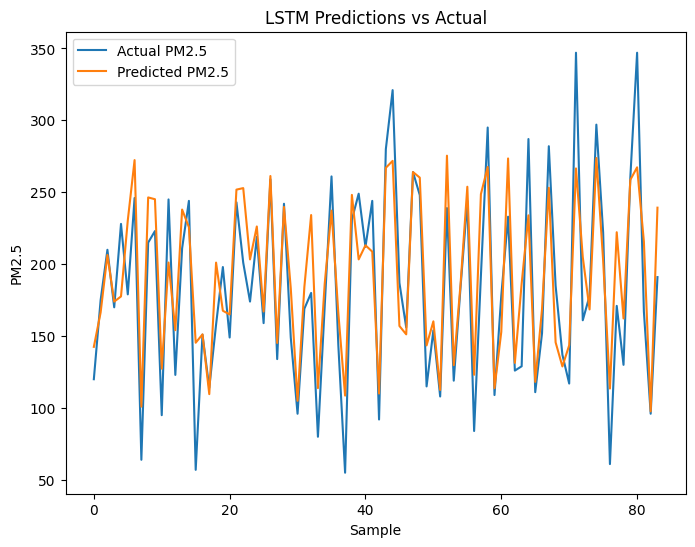

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(y_test_inv, label='Actual PM2.5')
plt.plot(y_pred_inv, label='Predicted PM2.5')
plt.legend()
plt.title('LSTM Predictions vs Actual')
plt.xlabel('Sample')
plt.ylabel('PM2.5')
plt.show()


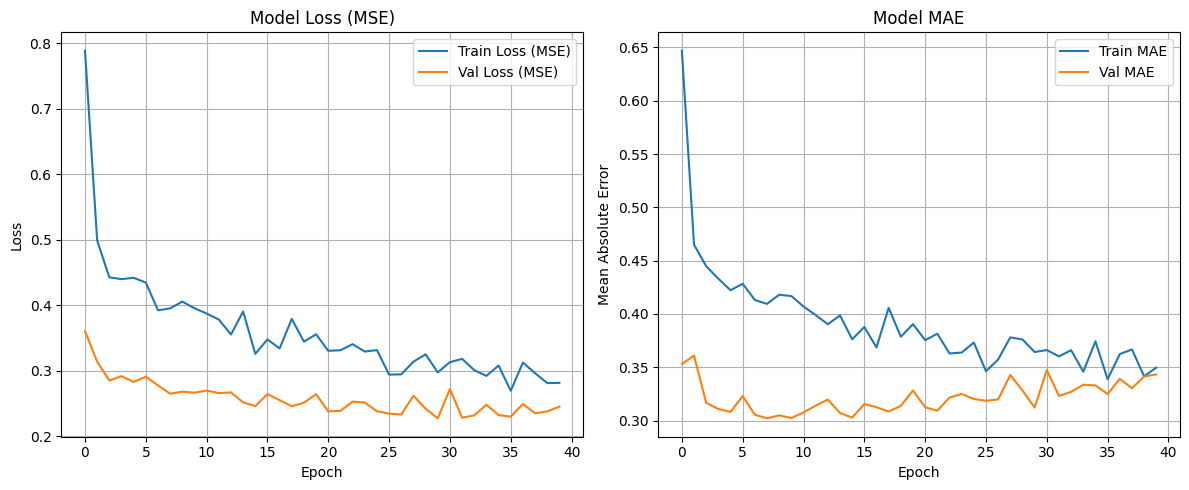

In [27]:
# Plot training & validation loss values
plt.figure(figsize=(12, 5))

# Loss (MSE)
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss (MSE)')
plt.plot(history.history['val_loss'], label='Val Loss (MSE)')
plt.title('Model Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
